In [1]:
!pwd

/home/giakhang/dev/RDPN6D


In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
import os.path as osp

from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode

from mmcv import Config

import time

from core.gdrn_modeling.models.GDRN import get_xyz_mask_region_out_dim, GDRN
from core.gdrn_modeling.models.resnet_backbone import ResNetBackboneNet, resnet_spec, RegNet, MyResNetBackboneNet
from core.gdrn_modeling.models.cdpn_rot_head_region import RotWithRegionHead
from core.gdrn_modeling.models.conv_pnp_net import ConvPnPNet
from core.gdrn_modeling.models.point_pnp_net import PointPnPNet, SimplePointPnPNet
from core.gdrn_modeling.models.resnet_backbone import ResNetBackboneNet, resnet_spec, RegNet, MyResNetBackboneNet

from core.utils.my_checkpoint import MyCheckpointer

import numpy as np
import mmcv
from PIL import Image
import json

from data_utils import (
    read_image_cv2, crop_resize_by_warp_affine, my_warp_affine, get_2d_coord_np
)
from preprocess_utils import *

from lib.pysixd import inout, misc

/home/giakhang/miniconda3/envs/rdpn6d/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
2025-03-25 10:41:51.664885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 10:41:51.824228: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from

In [2]:
config_file = "./configs/gdrn/a6_cPnP_lumi_piano.py"
#config_file = "./configs/gdrn/a6_cPnP_syn_lumi_piano.py"
#config_file = "./configs/gdrn/a6_cPnP_lumi_piano_external_camera.py"
cfg = Config.fromfile(config_file)

In [3]:
backbone_cfg = cfg.MODEL.CDPN.BACKBONE
r_head_cfg = cfg.MODEL.CDPN.ROT_HEAD
pnp_net_cfg = cfg.MODEL.CDPN.PNP_NET

In [4]:
block_type, layers, channels, name = resnet_spec[backbone_cfg.NUM_LAYERS]
backbone_net = ResNetBackboneNet(
    block_type, layers, backbone_cfg.INPUT_CHANNEL, freeze=backbone_cfg.FREEZE, rot_concat=r_head_cfg.ROT_CONCAT
)

In [5]:
r_out_dim, mask_out_dim, region_out_dim = get_xyz_mask_region_out_dim(
    cfg)
rot_head_net = RotWithRegionHead(
    cfg,
    channels[-1],
    r_head_cfg.NUM_LAYERS,
    r_head_cfg.NUM_FILTERS,
    r_head_cfg.CONV_KERNEL_SIZE,
    r_head_cfg.OUT_CONV_KERNEL_SIZE,
    rot_output_dim=r_out_dim,
    mask_output_dim=mask_out_dim,
    freeze=r_head_cfg.FREEZE,
    num_classes=r_head_cfg.NUM_CLASSES,
    rot_class_aware=r_head_cfg.ROT_CLASS_AWARE,
    mask_class_aware=r_head_cfg.MASK_CLASS_AWARE,
    num_regions=r_head_cfg.NUM_REGIONS,
    region_class_aware=r_head_cfg.REGION_CLASS_AWARE,
    norm=r_head_cfg.NORM,
    num_gn_groups=r_head_cfg.NUM_GN_GROUPS,
)

In [6]:
if r_head_cfg.XYZ_LOSS_TYPE in ["CE_coor", "CE"]:
    pnp_net_in_channel = r_out_dim - 3
else:
    pnp_net_in_channel = r_out_dim

if pnp_net_cfg.WITH_2D_COORD:
    pnp_net_in_channel += 2

if pnp_net_cfg.REGION_ATTENTION:
    pnp_net_in_channel += r_head_cfg.NUM_REGIONS

# do not add dim for none/mul
if pnp_net_cfg.MASK_ATTENTION in ["concat"]:
    pnp_net_in_channel += 1

if pnp_net_cfg.ROT_TYPE in ["allo_quat", "ego_quat"]:
    rot_dim = 4
elif pnp_net_cfg.ROT_TYPE in ["allo_log_quat", "ego_log_quat", "allo_lie_vec", "ego_lie_vec"]:
    rot_dim = 3
elif pnp_net_cfg.ROT_TYPE in ["allo_rot6d", "ego_rot6d"]:
    rot_dim = 6
else:
    raise ValueError(f"Unknown ROT_TYPE: {pnp_net_cfg.ROT_TYPE}")

pnp_head_cfg = pnp_net_cfg.PNP_HEAD_CFG
pnp_head_type = pnp_head_cfg.pop("type")
if pnp_head_type == "ConvPnPNet":
    pnp_head_cfg.update(
        nIn=pnp_net_in_channel,
        rot_dim=rot_dim,
        num_regions=r_head_cfg.NUM_REGIONS,
        featdim=128,
        num_layers=3,
        mask_attention_type=pnp_net_cfg.MASK_ATTENTION,
    )
    pnp_net = ConvPnPNet(**pnp_head_cfg)
elif pnp_head_type == "PointPnPNet":
    pnp_head_cfg.update(
        nIn=pnp_net_in_channel, rot_dim=rot_dim, num_regions=r_head_cfg.NUM_REGIONS)
    pnp_net = PointPnPNet(**pnp_head_cfg)
elif pnp_head_type == "SimplePointPnPNet":
    pnp_head_cfg.update(
        nIn=pnp_net_in_channel,
        rot_dim=rot_dim,
        mask_attention_type=pnp_net_cfg.MASK_ATTENTION,
        # num_regions=r_head_cfg.NUM_REGIONS,
    )
    pnp_net = SimplePointPnPNet(**pnp_head_cfg)
else:
    raise ValueError(f"Unknown pnp head type: {pnp_head_type}")

In [7]:
model = GDRN(cfg, backbone_net, rot_head_net,
    trans_head_net=None, pnp_net=pnp_net)

In [8]:
model.to(torch.device(cfg.MODEL.DEVICE))

GDRN(
  (backbone): ResNetBackboneNet(
    (spatial_net): md_pointnet(
      (xyz_emb): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (xb): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(67, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
      (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,

In [9]:
#ckpt_file = "/home/giakhang/dev/RDPN6D/output/gdrn/lumi_piano/residual_0831_32_5/model_0010599.pth"
#ckpt_file = "/home/giakhang/dev/RDPN6D/output/gdrn/syn_lumi_piano/syn_1/model_0009999.pth"
ckpt_file = "/home/giakhang/dev/RDPN6D/output/gdrn/lumi_piano/2025_03_11_01/model_0145349.pth"

_ = MyCheckpointer(model).resume_or_load(ckpt_file)

In [10]:
model.eval()

GDRN(
  (backbone): ResNetBackboneNet(
    (spatial_net): md_pointnet(
      (xyz_emb): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (xb): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(67, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
      (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,

In [11]:
img_id = 3
cls_id = 0
track_id = 7
roi_idx = 1

img_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/rgb/{img_id:05d}.png"
depth_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/depth/{img_id:05d}.png"
cam_info_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/scene_camera.json"
mask_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/scene_gt_info.json"

#img_path = f"./datasets/syn_lumi_piano_dataset/data/synthetic_data2/rgb/{img_id:05d}.png"
#depth_path = f"./datasets/syn_lumi_piano_dataset/data/synthetic_data2/depth/{img_id:05d}.png" 
#cam_info_path = "./datasets/syn_lumi_piano_dataset/data/synthetic_data2/scene_camera.json"
#mask_path = "./datasets/syn_lumi_piano_dataset/data/synthetic_data2/scene_gt_info.json"

#img_path = f"./datasets/lumi_piano_external_camera/data/track_05/rgb/{img_id:05d}.png"
#depth_path = f"./datasets/lumi_piano_external_camera/data/track_05/depth/{img_id:05d}.png" 
#cam_info_path = "./datasets/lumi_piano_external_camera/data/track_05/scene_camera.json"
#mask_path = "./datasets/lumi_piano_external_camera/data/track_05/scene_gt_info.json"

cad_path = "./datasets/lumi_piano_dataset/models/obj_000001.ply"


In [12]:
with open(mask_path, 'r') as f:
    mask = json.load(f)

In [13]:
image = read_image_cv2(img_path, "BGR")

#assert image.shape[:2] == (400, 640)

im_H, im_W = image_shape = image.shape[:2]  # h, w

with open(cam_info_path, 'r') as f:
    cam_dict = json.load(f)

K = np.array(cam_dict[f"{str(img_id)}"]["cam_K"], dtype=np.float32).reshape(3, 3)

input_res = cfg.MODEL.CDPN.BACKBONE.INPUT_RES
out_res = cfg.MODEL.CDPN.BACKBONE.OUTPUT_RES

coord_2d = get_2d_coord_np(im_W, im_H, low=0, high=1).transpose(1, 2, 0)

test_bbox_type = cfg.TEST.TEST_BBOX_TYPE
bbox_key = "bbox"

In [14]:
depth_img = np.array(Image.open(depth_path)).astype(np.float32)
depth_img = depth_img / 1000
depth_img = depth_img[:, :, np.newaxis]

In [15]:
num_fps_points = cfg.MODEL.CDPN.ROT_HEAD.NUM_REGIONS
objects = [
    "lumi_piano"
]

id2obj = {
    1: "lumi_piano"
}
obj2id = {_name: _id for _id, _name in id2obj.items()}

fps_points_path = "/home/giakhang/dev/RDPN6D/datasets/lumi_piano_dataset/models/fps_points.pkl"
fps_points = get_fps_points(num_fps_points, fps_points_path, objects, obj2id)[cls_id]

In [16]:
model_dir = "/home/giakhang/dev/RDPN6D/datasets/lumi_piano_dataset/models"
vertex_scale = 1
roi_extent = get_extents(objects, obj2id, model_dir, vertex_scale)[cls_id]

In [17]:
bbox = BoxMode.convert(mask[str(img_id)][roi_idx]["bbox_visib"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
x1, y1, x2, y2 = bbox

bbox_center = np.array([0.5 * (x1 + x2), 0.5 * (y1 + y2)])
bw = max(x2 - x1, 1)
bh = max(y2 - y1, 1)
scale = max(bh, bw) * cfg.INPUT.DZI_PAD_SCALE
scale = min(scale, max(im_H, im_W)) * 1.0

roi_wh = np.array([bw, bh], dtype=np.float32)
resize_ratio = out_res / scale

In [18]:
roi_img = crop_resize_by_warp_affine(
    image, bbox_center, scale, input_res, interpolation=cv2.INTER_LINEAR
).transpose(2, 0, 1)

pixel_mean = [0.0, 0.0, 0.0]
pixel_std = [255.0, 255.0, 255.0]

roi_img = normalize_image(pixel_mean, pixel_std, roi_img)

resize_ratio = out_res / scale

depth_img2 = crop_resize_by_warp_affine(
    depth_img, bbox_center, scale, input_res, interpolation=cv2.INTER_LINEAR
)
depth_img2 = depth_img2[:, :, np.newaxis]

rows, cols = 256, 256
ymap = np.array([[j for i in range(cols)]
                for j in range(rows)]).astype(np.float32)
xmap = np.array([[i for i in range(cols)]
                for j in range(rows)]).astype(np.float32)

In [19]:
H = my_warp_affine(coord_2d, bbox_center, scale,
                    input_res, interpolation=cv2.INTER_LINEAR)
offset_matrix = np.zeros((3, 3))
offset_matrix[:2, :] = H
offset_matrix[2][2] = 1

depth_img2 = depth_img2 / resize_ratio
newCameraK = np.matmul(offset_matrix, K)

cam_cx = newCameraK[0][2]
cam_cy = newCameraK[1][2]
cam_fx = newCameraK[0][0]
cam_fy = newCameraK[1][1]
xmap_masked = xmap[:, :, np.newaxis]
ymap_masked = ymap[:, :, np.newaxis]
pt2 = depth_img2.astype(np.float32)
pt0 = (xmap_masked - cam_cx) * pt2 / cam_fx
pt1 = (ymap_masked - cam_cy) * pt2 / cam_fy
depth_xyz = np.concatenate(
    (pt0, pt1, pt2), axis=2).transpose(2, 0, 1)

roi_img = np.concatenate((roi_img, depth_xyz), axis=0)

In [20]:
roi_coord_2d = crop_resize_by_warp_affine(
    coord_2d, bbox_center, scale, out_res, interpolation=cv2.INTER_LINEAR
).transpose(2, 0, 1)  # HWC -> CHW

roi_coord_2d = np.concatenate((depth_xyz[:, ::4, ::4], roi_coord_2d)).astype("float32")

In [21]:
roi_img = torch.as_tensor(np.array([roi_img])).contiguous().to("cuda", dtype=torch.float32)
roi_coord_2d = torch.as_tensor(np.array([roi_coord_2d])).contiguous().to("cuda", dtype=torch.float32)
fps = torch.as_tensor(np.array([fps_points])).contiguous().to("cuda", dtype=torch.float32)

roi_classes = torch.as_tensor(np.array([0])).to("cuda", dtype=torch.long)
K = torch.as_tensor(np.array([K])).to("cuda", dtype=torch.float32)
roi_wh = torch.as_tensor(np.array([roi_wh])).to("cuda", dtype=torch.float32)
roi_center = torch.as_tensor(np.array([bbox_center])).to("cuda", dtype=torch.float32)
resize_ratio = torch.as_tensor(np.array([resize_ratio])).to("cuda", dtype=torch.float32)
roi_extent = torch.as_tensor(np.array([roi_extent])).to("cuda", dtype=torch.float32)

In [22]:
out_dict = model(
    roi_img,
    roi_classes=roi_classes,
    roi_cams=K,
    roi_whs=roi_wh,
    roi_centers=roi_center,
    resize_ratios=resize_ratio,
    roi_coord_2d=roi_coord_2d,
    roi_extents=roi_extent,
    fps=fps
)

In [32]:
pred_R = out_dict["rot"].detach().cpu().numpy()[0]
pred_t = out_dict["trans"].detach().cpu().numpy()[0] 

In [34]:
(pred_t.flatten() * 1000).tolist()

[255.5868682861328, -59.27021789550781, 726.720703125]

In [24]:
lumi_piano_model = inout.load_ply(cad_path, vertex_scale=1)

lumi_piano_model["bbox3d_and_center"] = misc.get_bbox3d_and_center(lumi_piano_model["pts"])
kpts_3d = lumi_piano_model["bbox3d_and_center"]

In [25]:
kpts_2d = misc.project_pts(kpts_3d, K.cpu().numpy()[0], pred_R, pred_t)

img = read_image_cv2(img_path, format="BGR")
img_vis_kpts2d = misc.draw_projected_box3d(img.copy(), kpts_2d)

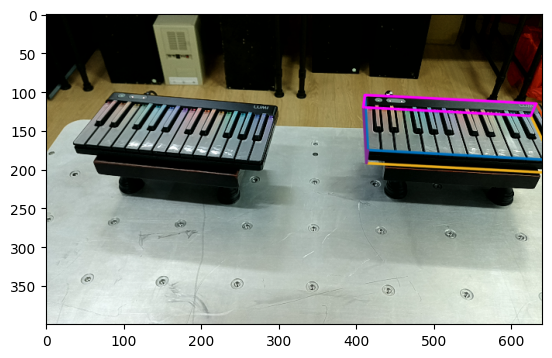

In [26]:
plt.imshow(img_vis_kpts2d[..., ::-1])